In [0]:
!unzip ./Corpora.zip -d ./
!git clone https://github.com/OpenNMT/OpenNMT-py.git
!python ./OpenNMT-py/setup.py install
!pip install -U torchtext
!nvidia-smi
!mkdir ./data ./models ./predictions

In [0]:
!python OpenNMT-py/tools/learn_bpe.py \
-i ./Corpora/En2Fa-Translation/Train/train.en \
-o ./data/src.code \
-s 4000

In [0]:
!python OpenNMT-py/tools/learn_bpe.py \
-i ./Corpora/En2Fa-Translation/Train/train.fa \
-o ./data/tgt.code \
-s 4000

In [0]:
!python OpenNMT-py/tools/apply_bpe.py \
-c ./data/src.code \
-i ./Corpora/En2Fa-Translation/Train/train.en \
-o ./data/train-bpe.en

In [0]:
!python OpenNMT-py/tools/apply_bpe.py \
-c ./data/src.code \
-i ./Corpora/En2Fa-Translation/Dev/dev.en \
-o ./data/dev-bpe.en

In [0]:
!python OpenNMT-py/tools/apply_bpe.py \
-c ./data/src.code \
-i ./Corpora/En2Fa-Translation/Test/test.en \
-o ./data/test-bpe.en

In [0]:
!python OpenNMT-py/tools/apply_bpe.py \
-c ./data/tgt.code \
-i ./Corpora/En2Fa-Translation/Train/train.fa \
-o ./data/train-bpe.fa

In [0]:
!python OpenNMT-py/tools/apply_bpe.py \
-c ./data/tgt.code \
-i ./Corpora/En2Fa-Translation/Dev/dev.fa \
-o ./data/dev-bpe.fa

In [0]:
!python OpenNMT-py/preprocess.py \
-train_src ./data/train-bpe.en \
-train_tgt ./data/train-bpe.fa \
-valid_src ./data/dev-bpe.en \
-valid_tgt ./data/dev-bpe.fa \
-save_data ./data/trans \
-src_seq_length 50 \
-tgt_seq_length 50 \
-lower

In [0]:
!python OpenNMT-py/train.py \
-data ./data/trans \
-src_word_vec_size 512 \
-tgt_word_vec_size 512 \
-encoder_type "rnn" \
-decoder_type "rnn" \
-layers 6 \
-rnn_size 512 \
-rnn_type "LSTM" \
-save_model ./models/trans \
-save_checkpoint_steps 2500 \
-gpu_ranks 0 \
-world_size 1 \
-seed 2020 \
-batch_size 32 \
-normalization "sents" \
-train_steps 50000 \
-early_stopping 0 \
-optim "adam" \
-max_grad_norm 5 \
-dropout 0.4 \
-learning_rate 0.001 \
-learning_rate_decay 0.8 \
-start_decay_steps 10000 \
-decay_steps 5000 \
-decay_method "none" \
-warmup_steps 1000 \
-report_every 500 \
-log_file "stats.txt"

In [0]:
import os
import subprocess
import matplotlib.pyplot as plt

In [0]:
def execute(cmd):
    process = subprocess.Popen(
        cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    (result, error) = process.communicate()
    rc = process.wait()
    if rc != 0:
        print ("Error: failed to execute command: ", cmd)
        print (error.rstrip().decode("utf-8"))
    return result.rstrip().decode("utf-8"), error.rstrip().decode("utf-8")

In [0]:
files_list = sorted(
    os.listdir('./models'), 
    key=lambda x: int(x[len('trans_step_'):-3])
)
bleu_file = open('bleu_results.txt', 'w')
for file in files_list:
    if file.startswith('trans'):
        num_step = int(file[len('trans_step_'):-3])
        pred_file = f'pred_step_{num_step}.txt'
        out = execute(f'python OpenNMT-py/translate.py \
        -model ./models/{file} -src ./data/dev-bpe.en \
        -output ./predictions/{pred_file} -replace_unk')
        out = execute(f'sed -i "s/@@ //g" ./predictions/{pred_file}')
        out = execute(f'perl OpenNMT-py/tools/multi-bleu.perl \
        ./Corpora/En2Fa-Translation/Dev/dev.fa < ./predictions/{pred_file}')
        print(f'Model {file} evaluation finished.')
        print(out)
        bleu_file.write(f'{num_step} {out[0]}\n')
bleu_file.close()

In [0]:
!python OpenNMT-py/translate.py \
-model ./models/trans_step_50000.pt \
-src ./data/test-bpe.en \
-output ./predictions/test.txt \
-replace_unk -verbose

[2020-05-27 10:21:33,035 INFO] Translating shard 0.
/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

SENT 1: ['hello', ',', 'do', 'we', 'drive', 'together', 'to', 'Hanover', 'on', 'the', 'twenty-eighth', 'of', 'March', '?']
PRED 1: سلام ، آیا ما هنوز باید در مورد یک زمانی در ماه می با تو صحبت کنیم ؟
PRED SCORE: -8.3936

SENT 2: ['it', 'is', 'more', 'comfortable', 'by', 'train', '.']
PRED 2: آن هم expensive است .
PRED SCORE: -3.0082

SENT 3: ['do', 'you', 'go', 'by', 'car', 'and', 'I', 'go', 'by', 'train', '?']
PRED 3: آیا شما تا قطار میخواهم در دفتر من ؟
PRED SCORE: -4.7973

SENT 4: ['I', 'would', 'like', 'to', 'go', 'by', 'train', '.', 'and', 'what', 'would', 'you', 'like', '?']
PRED 4: من دوست دارم شما را ببینم . آیا شما برای شما مناسب است ؟
PRED SCORE: -7.2759

SENT 5: ['if', 'we', 'take'

In [0]:
!sed -i "s/@@ //g" ./predictions/test.txt

In [0]:
!perl  OpenNMT-py/tools/multi-bleu.perl \
./Corpora/En2Fa-Translation/Test/test.fa0 \
./Corpora/En2Fa-Translation/Test/test.fa1 \
./Corpora/En2Fa-Translation/Test/test.fa2 \
./Corpora/En2Fa-Translation/Test/test.fa3 < ./predictions/test.txt

In [0]:
results = open('./stats.txt', 'r')
accuracies = []
steps = []
perplexities = []
for line in results:
    line = line.rstrip()
    if 'acc:' in line:
        print(line)
        accuracies.append(
            float(line[line.index('acc:')+6:line.index('ppl:')-2])
        )
        perplexities.append(
            float(line[line.index('ppl:')+5:line.index('xent:')-2])
        )
        steps.append(
            int(line[line.index('Step')+5:line.index('/50000')])
        )

Text(0, 0.5, 'perplexity')

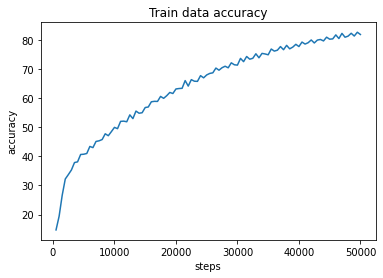

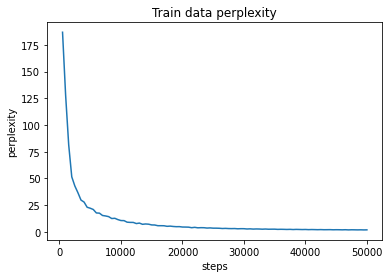

In [0]:
plt.plot(steps, accuracies)
plt.title('Train data accuracy')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.figure()
plt.plot(steps, perplexities)
plt.title('Train data perplexity')
plt.xlabel('steps')
plt.ylabel('perplexity')

In [0]:
results = open('./bleu_results.txt', 'r')
bleu_scores = []
steps = []
for line in results:
    line = line.rstrip()
    bleu_scores.append(
        float(line[line.index('BLEU')+7:line.index(',')])
    )
    steps.append(int(line[:line.index('BLEU')-3])*0.1)

Text(0, 0.5, 'BLEU')

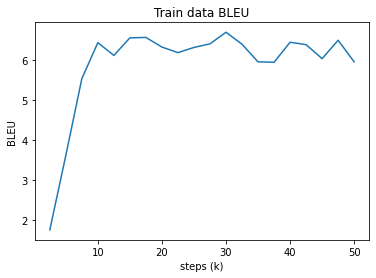

In [0]:
plt.figure()
plt.plot(steps, bleu_scores)
plt.title('Train data BLEU')
plt.xlabel('steps (k)')
plt.ylabel('BLEU')